In [1]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt

In [20]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [21]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [22]:
env.action_space

Discrete(2)

In [23]:
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n
HIDDEN_SIZE = 256
model = torch.nn.Sequential(
    torch.nn.Linear(obs_size, HIDDEN_SIZE),
    torch.nn.ReLU(),
    torch.nn.Linear(HIDDEN_SIZE, n_actions),
    torch.nn.Softmax(dim=0),
)

In [6]:
print(model)

Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
  (3): Softmax(dim=0)
)


In [24]:
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
Horizon = 500
MAX_TRAJECTORIES = 500
gamma = 0.99
score = []

In [25]:
for trajectory in range(MAX_TRAJECTORIES):
    curr_state = env.reset()[0]
    done = False
    transitions = []

    for t in range(Horizon):
        act_prob = model(torch.from_numpy(curr_state).float())
        action = np.random.choice(np.array([0, 1]), p=act_prob.data.numpy())
        prev_state = curr_state
        curr_state, _, done, info, _ = env.step(action)
        transitions.append((prev_state, action, t + 1))
        if done:
            break
    score.append(len(transitions))
    reward_batch = torch.Tensor([r for (s, a, r) in transitions]).flip(
        dims=(0,)
    )
    batch_Gvals = []
    for i in range(len(transitions)):
        new_Gval = 0
        power = 0
        for j in range(i, len(transitions)):
            new_Gval = new_Gval + ((gamma**power) * reward_batch[j]).numpy()
            power += 1
        batch_Gvals.append(new_Gval)
    expected_returns_batch = torch.FloatTensor(batch_Gvals)
    expected_returns_batch /= expected_returns_batch.max()
    state_batch = torch.Tensor([s for (s, a, r) in transitions])
    action_batch = torch.Tensor([a for (s, a, r) in transitions])
    pred_batch = model(state_batch)
    prob_batch = pred_batch.gather(
        dim=1, index=action_batch.long().view(-1, 1)
    ).squeeze()

    loss = -torch.sum(torch.log(prob_batch) * expected_returns_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if trajectory % 50 == 0 and trajectory > 0:
        print(
            "Trajectory {}\tAverage Score: {:.2f}".format(
                trajectory, np.mean(score[-50:-1])
            )
        )

Trajectory 50	Average Score: 44.35
Trajectory 100	Average Score: 61.27
Trajectory 150	Average Score: 82.41
Trajectory 200	Average Score: 207.43
Trajectory 250	Average Score: 211.22
Trajectory 300	Average Score: 292.37
Trajectory 350	Average Score: 384.00
Trajectory 400	Average Score: 439.27
Trajectory 450	Average Score: 389.20


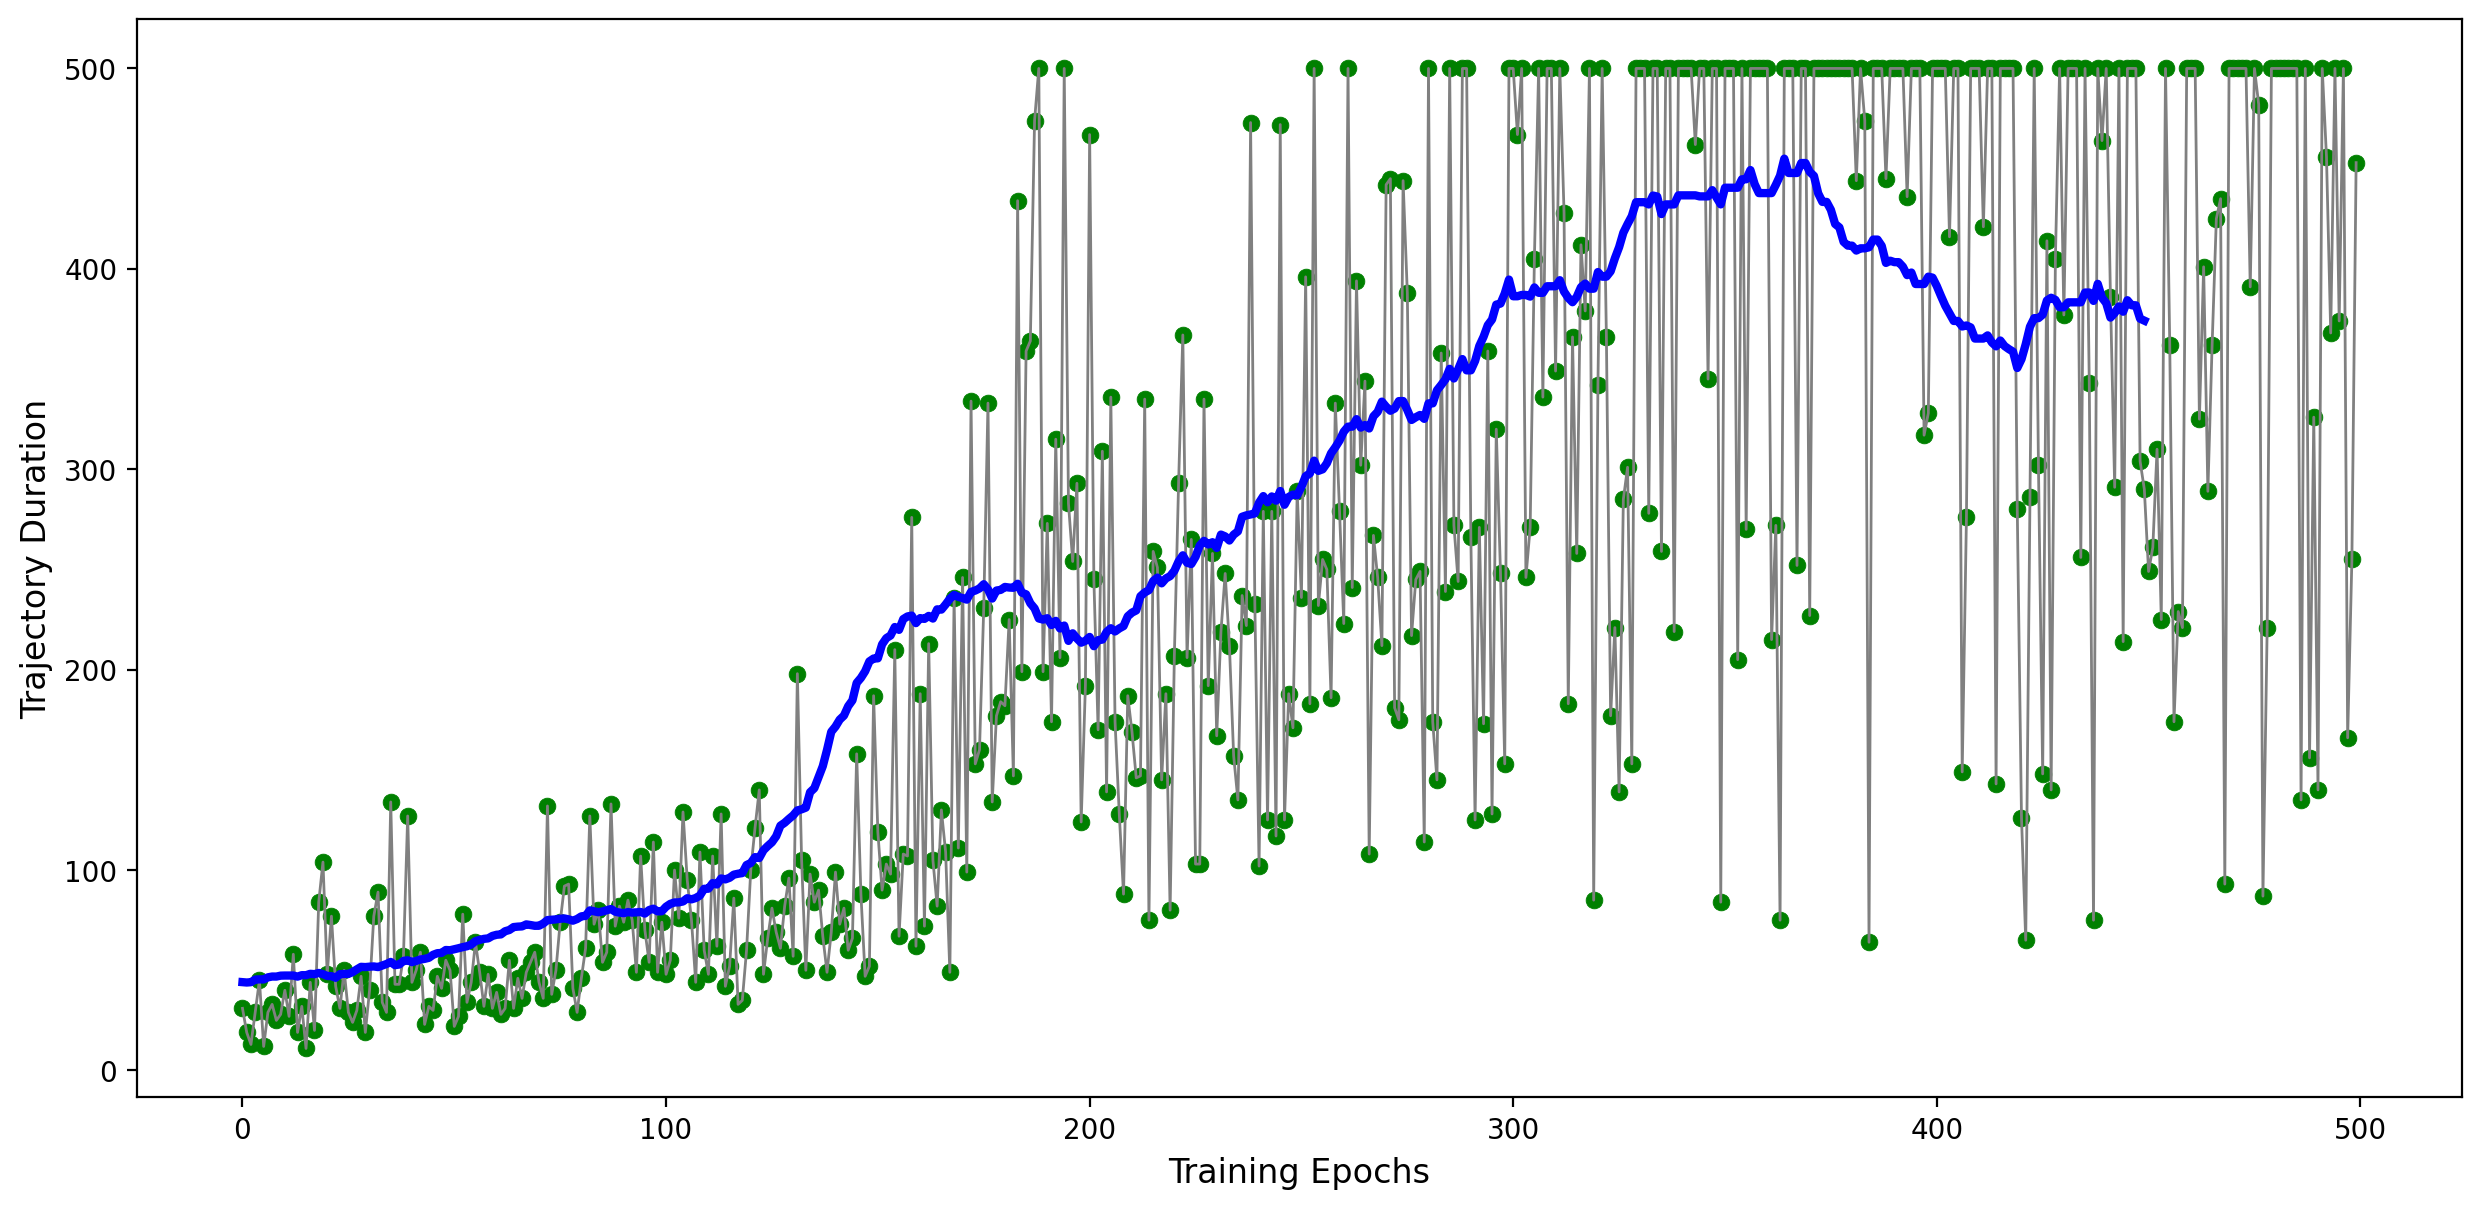

In [26]:
def running_mean(x):
    N = 50
    kernel = np.ones(N)
    conv_len = x.shape[0] - N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i : i + N]
        y[i] /= N
    return y


score = np.array(score)
avg_score = running_mean(score)
plt.figure(figsize=(15, 7))
plt.ylabel("Trajectory Duration", fontsize=12)
plt.xlabel("Training Epochs", fontsize=12)
plt.plot(score, color="gray", linewidth=1)
plt.plot(avg_score, color="blue", linewidth=3)
plt.scatter(np.arange(score.shape[0]), score, color="green", linewidth=0.3)

In [36]:
import base64
import imageio
import IPython


def embed_mp4(filename):
    video = open(filename, "rb").read()
    b64 = base64.b64encode(video)
    tag = """
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
    </video>""".format(b64.decode())
    return IPython.display.HTML(tag)


def create_policy_eval_video(model, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        for _ in range(num_episodes):
            state = env.reset()[0]
            video.append_data(env.render())
            while not done:
                pred = model(torch.from_numpy(state).float())
                action = np.random.choice(
                    np.array([0, 1]), p=pred.data.numpy()
                )
                state, _, done, _, _ = env.step(action)
                video.append_data(env.render())
    return embed_mp4(filename)


create_policy_eval_video(model, "trained-agent")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
